<a href="https://colab.research.google.com/github/millergw/cs181-s23-homeworks/blob/main/Bayesian_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# February 21st: Bayesian Regression

### CS181

#### Spring 2023

<img src="https://images2.imgbox.com/82/02/eGybE7NX_o.png" alt="image host"/>

## Learning Goals:

1. understand the effect of priors and number of data observations on the posterior
2. understand how to interpret the posterior predictive 

### Load necessary libraries

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [34]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
  prior_precision = np.linalg.inv(prior_variance)

  epsilon = 1e-5
  joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  joint_variance = np.linalg.inv(joint_precision + epsilon * np.ones(x_matrix.shape[1])) 
  joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior
  posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions + np.random.normal(0, noise_var**0.5, size=posterior_predictions.shape)

  return posterior_predictions, posterior_predictive_samples

def generate_data(number_of_points=10, noise_variance=0.5):
  #training x
  x = np.hstack((np.linspace(-10, -5, number_of_points), np.linspace(5, 10, number_of_points)))
  #function relating x and y
  f = lambda x:  0.01 * x**3
  #y is equal to f(x) plus gaussian noise
  y = f(x) + np.random.normal(0, noise_variance**0.5, 2 * N)
  x_test = np.linspace(-11, 11, 100)
  return x, y, x_test

## Build a Bayesian Model for Polynomial Regression
Recall that  a Bayesian model for polynomial regression has two pieces, the likelihood and the prior:
\begin{align}
y &= f_\mathbf{w}(\mathbf{x}) + \epsilon,\; \epsilon \sim \mathcal{N}(0, \sigma^2),\\
\mathbf{w} &\sim \mathcal{N}(0, \sigma_w^2 I)
\end{align}
where $I$ is a $DxD$ identity matrix, and $D$ is the number of parameters in $f_\mathbf{w}$.

The posterior of this Bayesian model $p(\mathbf{w} | \mathrm{Data})$ gives us a **distribution over likely model parameters** for the data, and thus, a **distribution over models** for the data. The posterior predictive gives us a distribution over predictions for any input $\mathbf{x}$.

**Exercise 1:** Explain the meaning of $\mathbf{0}$ in $\mathcal{N}(0, \sigma_\mathbf{w}^2 I)$ in terms of prior beliefs about the model -- what do we believe about $\mathbf{w}$? Explain $\sigma_\mathbf{w}^2$ in terms of uncertainty in our prior beliefs about the model -- how confidence are we in our beliefs about $\mathbf{w}$ if $\sigma_\mathbf{w}^2=1$ or $\sigma_\mathbf{w}^2 = 10$?

**Solution:** When we *assume* a zero-mean Gaussian prior for $\mathbf{w}$ we believe that the most likely value for $w_0$ and $w_1$ is zero -- that is, we believe that prior to seeing any data, the most likely model is a constant function (the zero function).

Since the covariance matrix for our prior on $\mathbf{w}$ is diagonal, this means that we believe that $w_0$ and $w_1$ have nothing to do with each other -- they are uncorrelated. The diagonal entries in the prior covariance matrix represent the variance in each $w_0$ and $w_1$, this variance quantifies our uncertainty in our belief about $w_0$ and $w_1$. When $\sigma_\mathbf{w}^2$ is large, the variance in $w_0$ and $w_1$ is large and so we are less certain in our belief that $w_0 = w_1 = 0$. Similarly, when $\sigma_\mathbf{w}^2$ is small we are more certain in our belief.


#### Let's generate some data

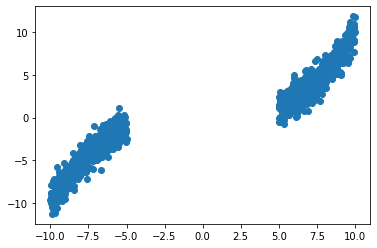

In [41]:
# number of data points in each of the two segments of the domain
N = 500 # 10, 500
# noise level in the data
noise_variance = 1.

# generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
plt.scatter(x_train, y_train)

**Exercise 2:** Fit a Bayesian polynomial regression model of degree 15 to the small provided dataset. Visualize the posterior predictive. Using this visualization, summarize where the model is the most confident in its predictions and where it is least confident.

Can you explain why the model is not confident in certain places but confident in others?

**Solutions:** Following our convention in this class, we use predictive variance as a measure of the model's confidence in its predictions. For non-Bayesian probabilistic models, we get a predictive distribution by bootstrapping many MLE models. For Bayesian models, we naturally get a distribution over plausible models (posterior), and hence a distribution over predictions (posterior predictive). 

In the following, on the left, we visualize models in the posterior (each line is one model sampled from the posterior). On the right, we visualize the posterior predictive distribution -- each model makes noisy predictions (i.e. we add observation noise to the predictions from models in the posterior). We visualize the 95% posterior predictive interval as a shaded tube around the data. Where this posterior predictive interval is wide, we are much more uncertain about the Bayesian model's predictions; where this posterior predictive interval is narrow, we are much more certain or confident about the Bayesian model's predictions.

We see that we have the most uncertainty in regions where there is no training data and we are the most certain in regions where there is a lot of training data.

This behavior fits with our understanding of Bayesian models -- when the number of observations is large, the posterior pdf is dominated by the likelihood; that is, the models deem likely by the posterior resemble those that best fit the data (e.g. the MLE). By looking at the math of the posterior distribution of Bayesian linear regression with Gaussian likelihood and Gaussian priors, we can see that we the number of observations is large the covariance matrix of the posterior is dominated by the data $\mathbf{X}^\top\mathbf{X}$. 

Let's consider the case where the input is 1-dimensional and equally spread out between [-10, 10], so the augmented matrix $\mathbf{X}$ looks like
$$
\mathbf{X} = \begin{pmatrix}
1 & x_0 = -10\\
\vdots & \vdots\\
1 & x_n\\
\vdots & \vdots\\
1 & x_N = 10
\end{pmatrix}
$$
and $\mathbf{X}^\top\mathbf{X}$ looks like
$$
\mathbf{X}^\top\mathbf{X} = \begin{pmatrix}
N & 0\\
0 & \sum_{n=1}^N x^2_n
\end{pmatrix}
$$
We remember that the posterior covariance matrix for this Bayesian linear regression model
\begin{aligned}
y &= w_1x + w_0 + \epsilon, \;\;\epsilon \sim \mathcal{N}(0, 0.5)\\
\mathbf{w} &\sim \mathcal{N}(\mathbf{0}, \sigma_\mathbf{w}^2I_{2\times 2}zs)
\end{aligned}
is as follows:
\begin{aligned}
\mathbf{\Sigma} &= \left(S^{-1} + 2\mathbf{X}^\top\mathbf{X} \right)^{-1}\\
&= \left( \begin{pmatrix}
\sigma^2_\mathbf{w} & 0\\
0 & \sigma^2_\mathbf{w}
\end{pmatrix}^{-1}
  + 2\begin{pmatrix}
N & \approx 0\\
\approx 0 & \sum_{n=1}^N x^2_n
\end{pmatrix} \right)^{-1}\\
&= \left( \begin{pmatrix}
\frac{1}{\sigma^2_\mathbf{w}} & 0\\
0 & \frac{1}{\sigma^2_\mathbf{w}}
\end{pmatrix}
  + 2\begin{pmatrix}
N & \approx 0\\
\approx 0 & \sum_{n=1}^N x^2_n
\end{pmatrix} \right)^{-1}\\
&= \begin{pmatrix}
\frac{1}{\sigma^2_\mathbf{w}} + 2N & \approx 0\\
\approx 0 & \frac{1}{\sigma^2_\mathbf{w}} + 2\sum_{n=1}^N x^2_n
\end{pmatrix}^{-1}\\
&= \begin{pmatrix}
\frac{1}{\frac{1}{\sigma^2_\mathbf{w}} + 2N} & \approx 0\\
\approx 0 & \frac{1}{\frac{1}{\sigma^2_\mathbf{w}} + 2\sum_{n=1}^N x^2_n}
\end{pmatrix}\\
\end{aligned}
From the above, we can see that when $N$ is large, the posterior variance in $w_0$ and $w_1$ becomes small.

In [42]:
# Hyperparams
PRIORVAR = 1 # 1, 0.001, 50
N = 500 # 10, 500

In [43]:
# Step 1: make an instance of the PolynomialFeatures model
poly = PolynomialFeatures(15)

# Step 2: fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [44]:
# Step 3: define the variance of the prior distribution
prior_variance = PRIORVAR
# Step 4: define the number of samples to take from the posterior
samples = 100

# Step 5: get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [45]:
# Step 6: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Step 7: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Step 8: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

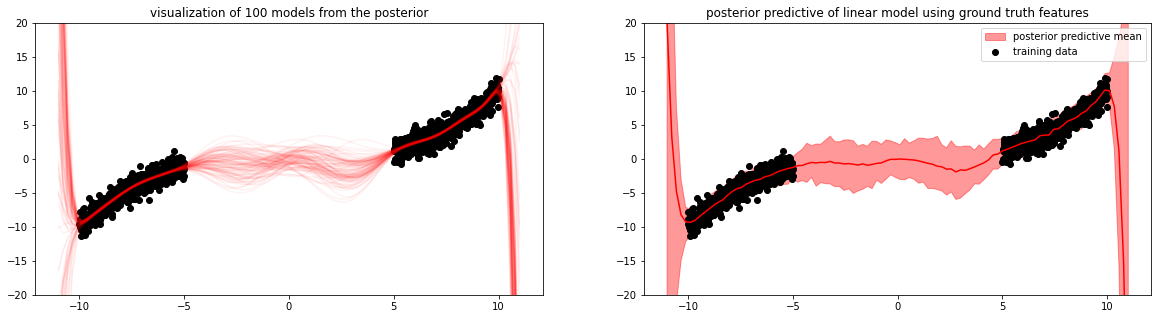

In [46]:
# Step 9: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05)

ax[0].set_ylim([-20, 20])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_test, pp_mean, color='red')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior predictive mean')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-20, 20])
plt.show()

**Exercise 3:** Change the prior variance $\sigma^2_w$ to 0.001 and visualize the posterior predictive. Change the prior variance $\sigma^2_w$ to 50 and visualize the posterior predictive. 

What is the effect of the prior variance on the posterior predictive? Why does the prior affect the posterior predictive in this way? Relate your answers to uncertainties.



**Exercise 4:** Change the number of data points $N$ in the dataset to 500 and visualize the posterior predictive. 

What is the effect of the number of data observations $N$ on the posterior predictive? Why does the number of data points $N$ affect the posterior predictive in this way? Support your answer with concepts from lecture.

**Exercise 5:** Change the noise variance $\sigma^2_y$ of the dataset to 10 and visualize the posterior predictive. Change the noise variance $\sigma^2_y$ of the dataset to 0.001 and visualize the posterior predictive. 

What is the effect of the noise variance $\sigma^2_y$ on the posterior predictive? Why does the noise variance $\sigma^2_y$ affect the posterior predictive in this way? Support your answer with concepts from lecture.